### Repeatable, Parallel Model Training and Model Tracking and Analysis  
  
In this notebook, you will use Azure Machine learning to create a repeatable, scaleable prediction framework. Key concepts in this notebook are:  
  
1. **Create and Run Inference Pipeline**
   - The [model inference script](../src/parallel_inference.py) is custom and interchangeable so it can be easily adapted for changing needs
   - The same compute cluster, and thus parallel and scaleable concepts, from [Step 1 - Model Training](./1_training_pipeline.ipynb) are used
   - The inference script uses MLFlow to automatically select and use the "best" model version from a given partitions registered models
     - For this notebook, the lowest test RMSE score is how "best" is defined
  
1. **Azure Machine Learning Endpoint / Deployment**
   -  You will also deploy the prediction pipeline to an Azure Machine Learning Batch Endpoint, this allows for:
      -  Scheduling or a programatic method to run the pipeline to generate predictions
      -  Deployment of multiple pipeline to the same endpoint for ease or conducting side-by-side comparison

In [2]:
# import required libraries
from azure.identity import DefaultAzureCredential
from azure.ai.ml import MLClient, Input, Output, load_component
from azure.ai.ml.dsl import pipeline
from azure.ai.ml.entities import BatchEndpoint, PipelineComponentBatchDeployment, Data
from azure.ai.ml.constants import AssetTypes, InputOutputModes
from azure.ai.ml.parallel import parallel_run_function, RunFunction
from dotenv import load_dotenv, find_dotenv
import pandas as pd
import glob
import os

In [3]:
# Initialize ML Client
load_dotenv(find_dotenv(), override=True)

# authenticate
credential = DefaultAzureCredential(tenantid=os.environ.get('TENANT_ID'))

# Get a handle to the workspace
ml_client = MLClient(
    credential=credential,
    subscription_id = os.environ.get('SUBSCRIPTION_ID'),
    resource_group_name = os.environ.get('RESOURCE_GROUP_NAME'),
    workspace_name = os.environ.get('WORKSPACE_NAME'),
)

print(dict(os.environ))

{'USER': 'zacksoenen', 'VSCODE_WSL_EXT_LOCATION': '/mnt/c/Users/zacksoenen/.vscode/extensions/ms-vscode-remote.remote-wsl-0.81.8', 'SHLVL': '1', 'HOME': '/home/zacksoenen', 'OLDPWD': '/mnt/c/Users/zacksoenen/AppData/Local/Programs/Microsoft VS Code', 'DBUS_SESSION_BUS_ADDRESS': 'unix:path=/run/user/1000/bus', 'WSL_DISTRO_NAME': 'Ubuntu', 'WAYLAND_DISPLAY': 'wayland-0', 'LOGNAME': 'zacksoenen', 'PULSE_SERVER': 'unix:/mnt/wslg/PulseServer', 'WSL_INTEROP': '/run/WSL/416_interop', 'NAME': 'TABLET-33MV54MS', '_': '/home/zacksoenen/miniconda3/envs/mm_remote/bin/python', 'TERM': 'xterm-color', 'PATH': '/home/zacksoenen/miniconda3/envs/mm_remote/bin:/home/zacksoenen/.vscode-server/bin/0ee08df0cf4527e40edc9aa28f4b5bd38bbff2b2/bin/remote-cli:/home/zacksoenen/miniconda3/envs/mm_remote/bin:/home/zacksoenen/miniconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/usr/lib/wsl/lib:/mnt/c/Program Files/Microsoft SDKs/Azure/CLI2/wbin:/mnt/c/Windows/s

### Define some input parameters

In [4]:
# Use remote environment created in step 1
custom_env_name = "mm-remote-env-py37"

In [5]:
# Acess data asset
data_name = "oj-sim-sales-test"
test_data_asset = ml_client.data.get(data_name, label='latest')
print(test_data_asset.path)

azureml://subscriptions/9a729243-1221-42c5-824c-9e44cb2da98d/resourcegroups/many-models-rg/workspaces/mm-aml-wksp/datastores/workspaceblobstore/paths/LocalUpload/724411e17666e66d19b8612b775b7707/test_subset.csv


In [6]:
# Load data preparation component
partition_data = load_component(source="../src/components/partition_data/partition_data.yaml")

In [7]:
cpu_compute_target = "mm-cpu-cluster"

In [8]:
azureml_tracking_uri = ml_client.workspaces.get(ml_client.workspace_name).mlflow_tracking_uri

### Define and Run Pipeline

In [9]:
# Create parallel inference step
# Declare parallel job, with a run_function task
many_model_inference_with_partition_keys = parallel_run_function(
    name="distributed_inference",
    display_name="Many Model Predictions",
    description="parallel job to batch predict with many models",
    inputs=dict(
        data_source=Input(
            type=AssetTypes.MLTABLE,
            description="Input mltable with predefined partition format.",
            mode=InputOutputModes.DIRECT,  # [Important] To use 'partition_keys', input MLTable is required to use 'direct' mode.
        ),
        drop_cols=Input(
            type="string",
            description="Columns need to be dropped before training. Split by comma.",
        ),
        experiment_names=Input(
            type="string",
            description="Name of training experiement(s) to be used to select best model. Split by comma.",
        ),
        metric_name=Input(
            type="string",
            description="Name of metric to be used to select best model, to be used in mlflow query. i.e. test_remse",
        ),
        date_col=Input(
            type="string",
            description="Name of date column in data",
        ),
        tracking_uri=Input(
            type="string",
            description="tracking uri of mlflow server (aml workspace)",
        ),
    ),
    outputs=dict(
        output_dir=Output(
            type=AssetTypes.URI_FOLDER,
            mode=InputOutputModes.RW_MOUNT,
        )
    ),
    input_data="${{inputs.data_source}}",  # Define which input data will be splitted into mini-batches
    partition_keys=["Store","Brand"],  # Use 'partition_keys' as the data division method. This method requires MLTable input with partition setting pre-defined in MLTable artifact.
    instance_count=6,  # Use X nodes from compute cluster to run this parallel job.
    max_concurrency_per_instance=2,  # Create 2 worker processors in each compute node to execute mini-batches.
    error_threshold=-1,  # Monitor the failures of item processed by the gap between mini-batch input count and returns. 'Many model training' scenario doesn't fit this setting and '-1' means ignore counting failure items by mini-batch returns.
    mini_batch_error_threshold=5,  # Monitor the failed mini-batch by exception, time out, or null return. When failed mini-batch count is higher than this setting, the parallel job will be marked as 'failed'.
    retry_settings=dict(
        max_retries=1,  # Define how many retries when mini-batch execution is failed by exception, time out, or null return.
        timeout=60,  # Define the timeout in second for each mini-batch execution.
    ),
    logging_level="DEBUG", # DEBUG, INFO, WARNING, ERROR, ETC
    task=RunFunction(
        code="../src/",
        entry_script="parallel_inference.py",
        environment=ml_client.environments.get(custom_env_name, label="latest"),
        program_arguments="--drop_cols ${{inputs.drop_cols}} "  # Passthrough input parameters into parallel_train script.
        "--experiment_names ${{inputs.experiment_names}} "
        "--metric_name ${{inputs.metric_name}} "
        "--tracking_uri ${{inputs.tracking_uri}} "
        "--date_col ${{inputs.date_col}} "
        "--output_dir ${{outputs.output_dir}} ",
    ),
)

In [10]:
# Build Pipeline
# Declare the overall input of the job.
test_oj_data = Input(
    path=test_data_asset.path,
    type=AssetTypes.URI_FILE,
    mode=InputOutputModes.RO_MOUNT,
)

# Declare pipeline structure.
@pipeline(display_name="inference pipeline")
def parallel_inference_pipeline(pipeline_input_data: Input(type=AssetTypes.MLTABLE)):
    
    # Declare 1st data partition command job.
    partition_job = partition_data(
        data_source=pipeline_input_data,
        partition_keys="Store,Brand",
    )

    # Declare 2nd parallel model training job.
    parallel_inference = many_model_inference_with_partition_keys(
        data_source=partition_job.outputs.tabular_output_data,
        drop_cols="Advert,Store,Brand",
        experiment_names="many-models-parallel-training-job-mlflow-full",
        metric_name="test_rmse",
        date_col="WeekStarting",
        tracking_uri=azureml_tracking_uri
    )
    
    return {"pipeline_output": parallel_inference.outputs.output_dir}

    # User could override parallel job run-level property when invoke that parallel job/component in pipeline.
    # parallel_train.resources.instance_count = 5
    # parallel_train.max_concurrency_per_instance = 2
    # parallel_train.mini_batch_error_threshold = 10

# Create pipeline instance
inference_pipeline = parallel_inference_pipeline(pipeline_input_data=test_oj_data,)

# Set pipeline level compute
inference_pipeline.settings.default_compute = cpu_compute_target
print(inference_pipeline)

Class AutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class AutoDeleteConditionSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseAutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class IntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class ProtectionLevelSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseIntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


display_name: inference pipeline
type: pipeline
inputs:
  pipeline_input_data:
    mode: ro_mount
    type: uri_file
    path: azureml://subscriptions/9a729243-1221-42c5-824c-9e44cb2da98d/resourcegroups/many-models-rg/workspaces/mm-aml-wksp/datastores/workspaceblobstore/paths/LocalUpload/724411e17666e66d19b8612b775b7707/test_subset.csv
outputs:
  pipeline_output:
    mode: rw_mount
    type: uri_folder
jobs:
  partition_job:
    type: command
    inputs:
      data_source:
        path: ${{parent.inputs.pipeline_input_data}}
      partition_keys: Store,Brand
    component:
      $schema: https://azuremlschemas.azureedge.net/latest/commandComponent.schema.json
      name: partition_data
      version: '1'
      display_name: Partition data by keys
      type: command
      inputs:
        data_source:
          type: uri_file
        partition_keys:
          type: string
      outputs:
        tabular_output_data:
          type: mltable
      command: python partition_data.py --data_s

In [11]:
# Run Inference Pipeline (optional)
pipeline_job = ml_client.jobs.create_or_update(
    inference_pipeline,
    experiment_name="many-models-parallel-inference-job",
)

### Create and Deploy as a Batch Endpoint

In [16]:
# Create Batch Endpoint

endpoint_name = "manymodels-batch-endp-demo"
print(f"Endpoint name: {endpoint_name}")

endpoint = BatchEndpoint(
    name=endpoint_name,
    description="A many models batch inference endpoint",
)

try:
    ml_client.batch_endpoints.get(endpoint_name)
    print(f"'{endpoint_name}' endpoint already exists. Will re-use existing endpoint")
except Exception as e:
    print("No existing endpoint found. Creating new endpoint....")
    ml_client.batch_endpoints.begin_create_or_update(endpoint).result()
    print("Complete.")

Endpoint name: manymodels-batch-endp-demo
'manymodels-batch-endp-demo' endpoint already exists. Will re-use existing endpoint


In [17]:
# Define Pipeline Component
pipeline_component = parallel_inference_pipeline().component

# Register Pipeline Component for better tracking and versioning
ml_client.components.create_or_update(pipeline_component)

PipelineComponent({'intellectual_property': None, 'auto_increment_version': False, 'source': 'REMOTE.WORKSPACE.COMPONENT', 'is_anonymous': False, 'auto_delete_setting': None, 'name': 'parallel_inference_pipeline', 'description': None, 'tags': {}, 'properties': {}, 'print_as_yaml': True, 'id': '/subscriptions/9a729243-1221-42c5-824c-9e44cb2da98d/resourceGroups/many-models-rg/providers/Microsoft.MachineLearningServices/workspaces/mm-aml-wksp/components/parallel_inference_pipeline/versions/2024-01-16-19-28-08-7682241', 'Resource__source_path': None, 'base_path': '/home/zacksoenen/Projects/many-models-azureml/demo_notebooks', 'creation_context': <azure.ai.ml._restclient.v2022_10_01.models._models_py3.SystemData object at 0x7f528f730cd0>, 'serialize': <msrest.serialization.Serializer object at 0x7f52901294d0>, 'version': '2024-01-16-19-28-08-7682241', 'latest_version': None, 'schema': None, 'type': 'pipeline', 'display_name': 'inference pipeline', 'is_deterministic': False, 'inputs': {'pipe

In [29]:
# Create Deployment
deployment_name = "many-models-inference-deployment"

deployment = PipelineComponentBatchDeployment(
    name=deployment_name,
    description="A many models deployment.",
    endpoint_name=endpoint_name,
    component=pipeline_component,
    settings={"default_compute": cpu_compute_target},
)

try:
    ml_client.batch_deployments.get(name=deployment_name, endpoint_name=endpoint_name)
    print(f"'{deployment_name}' already exists. Will re-use existing.")
except Exception as e:
    print("No existing deployment found. Creating new deployment....")
    ml_client.batch_deployments.begin_create_or_update(deployment).result()
    print("Complete.")

'many-models-inference-deployment' already exists. Will re-use existing.


In [47]:
# Invoke Batch endpoint
input_data = test_oj_data

endp_job = ml_client.batch_endpoints.invoke(
    endpoint_name=endpoint_name,
    deployment_name=deployment_name,
    inputs={"pipeline_input_data": input_data},
)

In [60]:
ml_client.jobs.stream(name=endp_job.name)

RunId: dd2068e4-147d-4ff3-8dd8-6af1f845c855
Web View: https://ml.azure.com/runs/dd2068e4-147d-4ff3-8dd8-6af1f845c855?wsid=/subscriptions/9a729243-1221-42c5-824c-9e44cb2da98d/resourcegroups/many-models-rg/workspaces/mm-aml-wksp


Navigate to the Portal to monitor job progress. Wait for job to complete:  
  
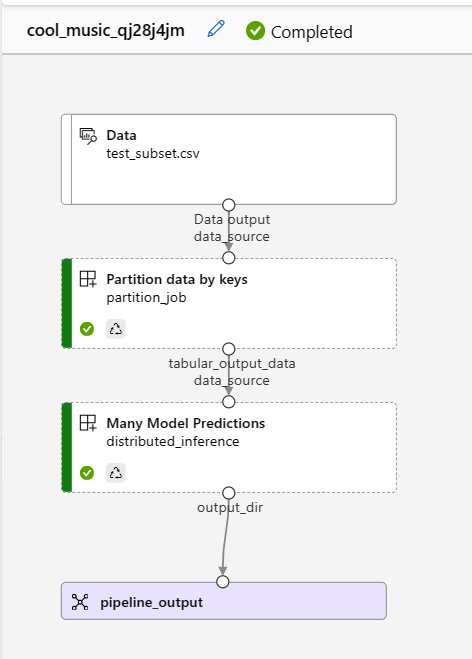

### Analyze Outputs ###

In [ ]:
# Download output data
local_download_path = "../data/oj_sim_sales/outputs/"
ml_client.jobs.download(name=endp_job.name, download_path=local_download_path, output_name="pipeline_output")

In [56]:
# Read output data as pandas df

glob_path = os.path.join(local_download_path +"named-outputs/pipeline_output/*.csv")
output_files = glob.glob(glob_path)
output_df = pd.concat((pd.read_csv(f) for f in output_files))

display(len(output_df))
display(output_df.head())

1386

,WeekStarting,Advert,Price,Store,Brand,predictions
0,1992-07-02,True,2.55,1028,minute_maid,35169.553746
1,1992-07-09,True,2.07,1028,minute_maid,31636.904183
2,1992-07-16,True,2.04,1028,minute_maid,31391.641231
3,1992-07-23,True,2.17,1028,minute_maid,28728.226342
4,1992-07-30,True,2.16,1028,minute_maid,24841.971246


## Register Output as a AML Data Asset

In [ ]:
# Register predictions as a data asset

predictions_csv_path = "../data/oj_sim_sales/outputs/consolidated_outputs.csv"

output_df.to_csv(predictions_csv_path, index=False)

inference_output = Data(
    name="oj-sim-sales-predictions",
    version='v1',
    description="Lab 02 output file",
    path=predictions_csv_path,
    type=AssetTypes.URI_FILE,
)

ml_client.data.create_or_update(inference_output)

Data({'skip_validation': False, 'mltable_schema_url': None, 'referenced_uris': None, 'type': 'uri_file', 'is_anonymous': False, 'auto_increment_version': False, 'auto_delete_setting': None, 'name': 'oj-sim-sales-predictions', 'description': 'Lab 02 output file', 'tags': {}, 'properties': {}, 'print_as_yaml': True, 'id': '/subscriptions/9a729243-1221-42c5-824c-9e44cb2da98d/resourceGroups/many-models-rg/providers/Microsoft.MachineLearningServices/workspaces/mm-aml-wksp/data/oj-sim-sales-predictions/versions/v1', 'Resource__source_path': None, 'base_path': '/home/zacksoenen/Projects/many-models-azureml/demo_notebooks', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x7f1147974d50>, 'serialize': <msrest.serialization.Serializer object at 0x7f1147974fd0>, 'version': 'v1', 'latest_version': None, 'path': 'azureml://subscriptions/9a729243-1221-42c5-824c-9e44cb2da98d/resourcegroups/many-models-rg/workspaces/mm-aml-wksp/datastores/workspaceblobstore/paths/LocalUploa